# Binary, barrier and Asian options

In this notebook we want to study the problem of pricing some exotic derivatives by solving their associated PDE.

I will use the same framework, based on the implicit discretization, presented in the Black-Scholes PDE notebook **2.1**.
The results are then compared with the values obtained from other numerical methods.

## Contents
   - [Digital/Binary options](#sec1)
      - [Numerical solution](#sec1.1)
   - [Barrier options](#sec2)
      - [Numerical solution](#sec2.1)
   - [Asian options](#sec3)
      - [Numerical solution: Monte Carlo](#sec3.1)
      - [Fixed strike](#sec3.2)
      - [Floating strike](#sec3.3)

In [1]:
from functions.BS_pricer import BS_pricer
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

In [2]:
# Option variables
S0=100.0              # spot stock price
K=100.0               # strike
T=1.0                 # maturity 
r=0.1                 # risk free rate 
sig=0.2               # diffusion coefficient or volatility
X0 = np.log(S0)       # logprice
B = 120               # Barrier

<a id='sec1'></a>
## Binary/digital options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Binary_option)

Let us consider the case of a **cash or nothing CALL** binary option:

\begin{equation}
V(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ \mathbb{1}_{\{S_T > K\}} \, \big| \, S_t=s \bigr].
\end{equation}

where, as usual, $\mathbb{Q}$ is the risk neutral measure.

<a id='sec1.1'></a>
## Numerical solution

#### Closed formula

In [3]:
d2 = (np.log(S0/K) + (r - sig**2 / 2) * T) / (sig * np.sqrt(T))
N2 = ss.norm.cdf(d2)
closed_digital = np.exp(-r*T) * N2
print("The price of the ATM digital call option by closed formula is: ", closed_digital)

The price of the ATM digital call option by closed formula is:  0.5930501164033175


#### Monte Carlo

In [4]:
np.random.seed(seed=42)
N_simulation = 20000000
W = (r - sig**2/2)*T  + ss.norm.rvs(loc=0, scale=sig, size=N_simulation)
S_T = S0 * np.exp(W)

MC_digital = np.exp(-r*T) * scp.mean( S_T > K )
digital_std_err = np.exp(-r*T) * ss.sem( S_T > K )
print("The price of the ATM digital call option by Monte Carlo is: ", MC_digital)
print("with standard error: ", digital_std_err)

The price of the ATM digital call option by Monte Carlo is:  0.593071342432063
with standard error:  9.615080192805355e-05


#### PDE method:

In [5]:
Nspace = 6000   # M space steps
Ntime = 6000    # N time steps   
S_max = 3*float(K)                
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
Payoff = np.where(np.exp(x)>K, 1, 0)          # Binary payoff

V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = 1                        # boundary condition
V[0,:] = 0                         # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx
a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = DD.solve(V[1:-1,i+1] - offset)     

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print("The price of the ATM digital call option by PDE is: ", oPrice)

The price of the ATM digital call option by PDE is:  0.5930462329429457


#### Plots

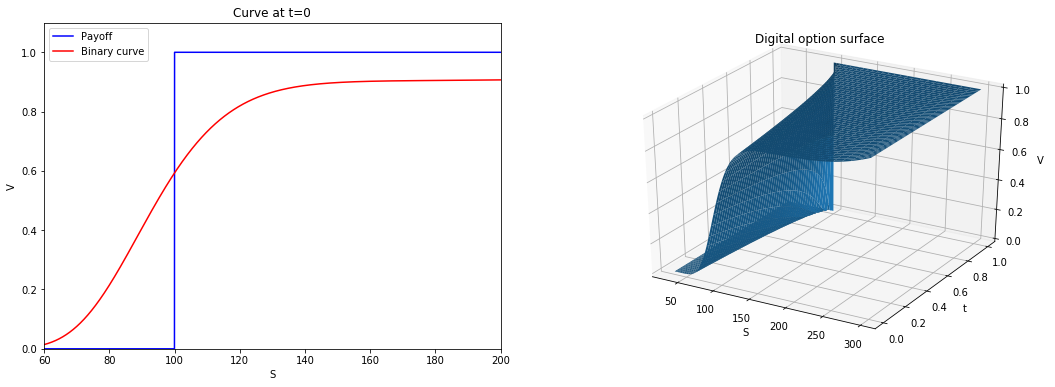

In [6]:
S = np.exp(x)
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122, projection='3d')
ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="Binary curve")
ax1.set_xlim(60,200); ax1.set_ylim(0,1.1)
ax1.set_xlabel("S"); ax1.set_ylabel("V"); ax1.legend(loc='upper left')
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Digital option surface"); ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
plt.show()

<a id='sec2'></a>
## Barrier options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Barrier_option)

Let us consider the case of an **Up and Out CALL** European option:

\begin{equation}
V(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \bigl[ (S_T - K)^+ \mathbb{1}_{\{M_T < B\}} \, \big| \, S_t=s \bigr].
\end{equation}

where I introduced the running max:

$$ M_T = \max_{0\leq t \leq T} S_t. $$

The parameter $B$ is the barrier.     
We have to assume that $B > K$, otherwise the payoff would be always zero. 

<a id='sec2.1'></a>
## Numerical solution

#### Closed formula:

I took the following formula from Chapter 7.3.3 of the reference book [3]. 

In [7]:
d1 = lambda t,s: 1/(sig*np.sqrt(t)) * ( np.log(s) + (r+sig**2/2)*t ) 
d2 = lambda t,s: 1/(sig*np.sqrt(t)) * ( np.log(s) + (r-sig**2/2)*t ) 

In [8]:
closed_barrier = S0 * ( ss.norm.cdf( d1(T, S0/K) ) - ss.norm.cdf( d1(T, S0/B) ) ) \
      - np.exp(-r*T) * K * ( ss.norm.cdf( d2(T, S0/K) ) - ss.norm.cdf( d2(T, S0/B) ) ) \
      - B * (S0/B)**(-2*r/sig**2) * ( ss.norm.cdf( d1(T, B**2/(S0*K) ) ) - ss.norm.cdf( d1(T, B/S0) ) ) \
      + np.exp(-r*T) * K * (S0/B)**(-2*r/sig**2 + 1) * \
      ( ss.norm.cdf( d2(T, B**2/(S0*K) ) ) - ss.norm.cdf( d2(T, B/S0) ) )

In [9]:
print("The price of the Up and Out call option by closed formula is: ", closed_barrier)

The price of the Up and Out call option by closed formula is:  1.1789018151004562


#### Monte Carlo:

In [10]:
%%time
np.random.seed(seed=42)
N = 10000
paths = 50000
dt = T/(N-1)          # time interval

#path generation
X_0 = np.zeros((paths,1))
increments = ss.norm.rvs(loc=(r-sig**2/2)*dt, scale=np.sqrt(dt)*sig, size=(paths,N-1))
X = np.concatenate((X_0,increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

M = np.amax(S, axis=1)      # maximum of each path

# discounted expected payoff
MC_barrier = np.exp(-r * T) * (np.maximum( S[:,-1] - K, 0 ) @ (M<B) )/ paths
barrier_std_err = np.exp(-r * T) * ss.sem( (np.maximum( S[:,-1] - K, 0 ) * (M<B) ) )

print("The price of the Up and Out call option by Monte Carlo is: ", MC_barrier)
print("with standard error: ", barrier_std_err); print()

The price of the Up and Out call option by Monte Carlo is:  1.2023400529852908
with standard error:  0.014051090829401498

CPU times: user 25.8 s, sys: 6.18 s, total: 32 s
Wall time: 35.5 s


It is well known that Monte Carlo methods are slow.

When working with path dependent options, such as Barrier options, it is necessary to generate the entire paths. This is SUPER slow!! 

With C and Cython it is possible to improve the performance.

There are several methods to improve the algorithm:
- using antithetic variables [wiki](https://en.wikipedia.org/wiki/Antithetic_variates) to reduce the total variance.
- using the Brownian bridge in order to reduce the error introduced by the time step discretization. Between two time points there is a non-zero probability that the process hits the barrier and returns back. We are missing this event, and this creates a positive bias in the final price (indeed our price is a bit higher).

Well we are happy with our price, which is very close to the correct (closed formula) price.

#### PDE method:

In [11]:
# PDE
Nspace = 14000   # M space steps
Ntime = 10000    # N time steps   
S_max = B        # The max of S corresponds to the Barrier           
S_min = float(K)/3
x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1

x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
Payoff = np.maximum(np.exp(x)-K,0)          # Call payoff

V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = 0                        # boundary condition
V[0,:] = 0                         # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig*sig; dxx = dx * dx
a = ( (dt/2) * ( (r-0.5*sig2)/dx - sig2/dxx ) )
b = ( 1 + dt * ( sig2/dxx + r ) )
c = (-(dt/2) * ( (r-0.5*sig2)/dx + sig2/dxx ) )
D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
DD = splu(D)

# Backward iteration
for i in range(Ntime-2,-1,-1):
    offset[0] = a * V[0,i]
    offset[-1] = c * V[-1,i]; 
    V[1:-1,i] = DD.solve(V[1:-1,i+1] - offset)     

# finds the option at S0
oPrice = np.interp(X0, x, V[:,0])
print("The price of the Up and Out option by PDE is: ", oPrice)

The price of the Up and Out option by PDE is:  1.1790256853164922


#### Plots

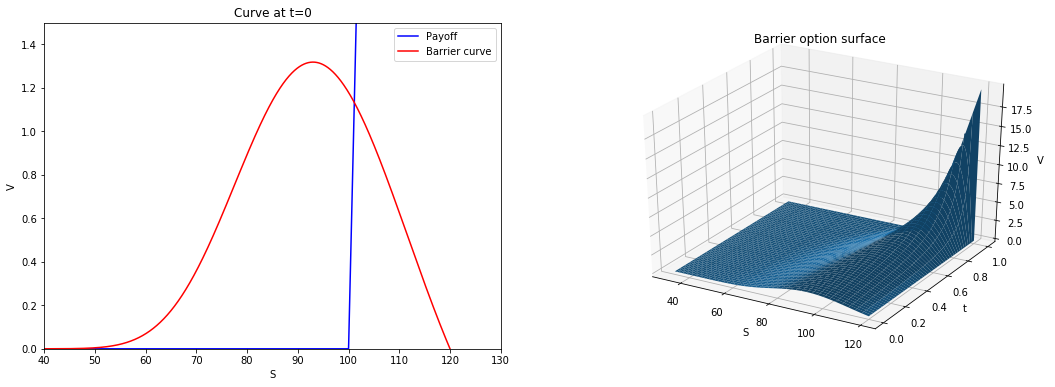

In [12]:
S = np.exp(x)
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,0], color='red',label="Barrier curve")
ax1.set_xlim(40,130); ax1.set_ylim(0,1.5)
ax1.set_xlabel("S"); ax1.set_ylabel("V"); ax1.legend(loc='upper right')
ax1.set_title("Curve at t=0")

X, Y = np.meshgrid(T_array, S)
ax2.plot_surface(Y, X, V)
ax2.set_title("Barrier option surface"); ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
plt.show()

<a id='sec3'></a>
## Asian options

For more info have a look at the [wiki page](https://en.wikipedia.org/wiki/Asian_option)

Let us consider the two cases: 
- **Fixed Strike Arithmetic Average CALL** European option:

\begin{equation}
V(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \biggl[ \biggl( A_T - K \biggr)^+ \, \bigg| \, S_t=s \biggr].
\end{equation}

- **Floating Strike Arithmetic Average CALL** European option:

\begin{equation}
V(t,s) = e^{- r (T-t)} \mathbb{E}^{\mathbb{Q}} \biggl[ \biggl( S_T  - A_T \biggr)^+ \, \bigg| \, S_t=s \biggr].
\end{equation}

where the term 

$$ A_t = \frac{1}{t} \int_0^t S_u du $$ 

represents the continuous time **arithmetic average** of the price process.

The PDE of the Asian option is obtain by an augmentation of the state i.e. the new state variable $A_t$ is introduced. This state variables has a dynamics described by the SDE:

$$ dA_t = \frac{S_t - A_t}{t} dt. $$

The Asian PDE is:

$$ \frac{\partial  V(t,a,s)}{\partial t}  
          + r\,s \frac{\partial V(t,a,s)}{\partial s} + \frac{s - a}{t} \frac{\partial V(t,a,s)}{\partial a}
          + \frac{1}{2} \sigma^2 s^2 \frac{\partial^2  V(t,a,s)}{\partial s^2} - r  V(t,a,s)  = 0. $$

with "unknown" lateral boundary conditions. It is not clear how $V(t,a,s)$ behaves when $a, s \to \pm \infty$.  
A derivation of a similar Asian PDE can be found in Theorem 7.5.1 of [3]. 

In order to simplify the problem, it is better to consider the two-dimensional PDE obtained by a *change of numeraire* or a *change of variable* for the case of **fixed strike** (see Theorem 7.5.3 of [3]) and  **floating strike** (see Section 6.1.2 of [1]) respectively. 

<a id='sec3.1'></a>
## Numerical solution

The price of the Asian option is not known in closed form. We will compute it by using Monte Carlo and PDE methods.

#### Monte Carlo:

In [13]:
%%time
np.random.seed(seed=41)
N = 10000
paths = 50000
dt = T/(N-1)          # time interval

#path generation
X_0 = np.zeros((paths,1))
increments = ss.norm.rvs(loc=(r-sig**2/2)*dt, scale=np.sqrt(dt)*sig, size=(paths,N-1))
X = np.concatenate((X_0,increments), axis=1).cumsum(1)
S = S0 * np.exp(X)

A = np.mean(S, axis=1)       # Average of each path
#A = S[:,-1]                 # Uncomment to retrieve the Black-Scholes price

# FIXED STRIKE
MC_asian_fixed = np.exp(-r * T) * np.mean( np.maximum( A - K, 0 ) )
asian_fixed_std_err = np.exp(-r * T) * ss.sem( np.maximum( A - K, 0 ) )
print("The price of the fixed strike average call option by Monte Carlo is: ", MC_asian_fixed)
print("with standard error: ", asian_fixed_std_err); print()

# FLOAT STRIKE
MC_asian_float = np.exp(-r * T) * np.mean( np.maximum( S[:,-1] - A, 0 ) )
asian_float_std_err = np.exp(-r * T) * ss.sem( np.maximum( S[:,-1] - A, 0 ) )
print("The price of the float strike average call option by Monte Carlo is: ", MC_asian_float)
print("with standard error: ", asian_float_std_err); print()

The price of the fixed strike average call option by Monte Carlo is:  7.026203431709784
with standard error:  0.03800140560040339

The price of the float strike average call option by Monte Carlo is:  7.285168879759573
with standard error:  0.04138857308481101

CPU times: user 26.7 s, sys: 5.58 s, total: 32.3 s
Wall time: 30.1 s


<a id='sec3.2'></a>
## Fixed strike. PDE method:

Let us consider the PDE:

$$ \frac{\partial  g(t,y)}{\partial t}  
          + \frac{1}{2} \sigma^2 \bigl(\gamma(t) - y\bigr)^2 \frac{\partial^2  g(t,y)}{\partial y^2}  = 0. $$

with boundary conditions:

$$ g(T,y) = y^+ $$

$$ g(t, -\infty) = 0 \quad \text{and} \quad g(t,y) \underset{y\to \infty}{\sim} y $$

where the function $\gamma(t) := \frac{1}{rT} (1 - e^{-r(T-t)})$.
This is derived in Section 7.5.3 of [3].

The solution of this PDE is related with the option price by the relation:

$$ V(t,a,s) := s \, g \bigg(t,\frac{x}{s} \bigg) $$

with $x := \frac{1}{rT} \bigl( 1-e^{-rT} \bigr) s - e^{-rT} K $.

We can discretize the computational domain and call $g(t_n, y_i) := g^n_i$, and then discretize the PDE using the usual implicit method (for a review, see the notebook **2.1**). We obtain:

$$ g^{n+1}_{i} = a^{n}_{i}\, g^{n}_{i-1} + b^{n}_{i}\, g^{n}_{i} + a^{n}_{i}\, g^{n}_{i+1} $$

with

$$
 a^{n}_{i} =  - \frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta y^2}  \biggl(\gamma(t_n) - y_i \biggr)^2  \quad
 \text{ and } \quad b^{n}_{i} = 1 + \sigma^2 \frac{\Delta t}{\Delta y^2} \biggl(\gamma(t_n) - y_i \biggr)^2 $$
 
The coefficients depend on time and space. We have to construct a new matrix $\mathcal{D}$ at each time step.

In [14]:
def gamma(t):
    return 1/(r*T) * ( 1 - np.exp(-r*(T-t)) )

def get_X0(S0):
    """ function that computes the variable x defined above """
    return gamma(0)*S0 - np.exp(-r*T) * K

In [15]:
# PDE algorithm
Nspace = 6000   # M space steps
Ntime = 6000    # N time steps   
y_max = 60      # A2
y_min = -60     # A1

y, dy = np.linspace(y_min, y_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)       # time discretization
Payoff = np.maximum(y,0)                                   # payoff 

G = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

G[:,-1] = Payoff                   # terminal conditions 
G[-1,:] = y_max                    # boundary condition
G[0,:] = 0                         # boundary condition

for n in range(Ntime-2,-1,-1):
    
    # construction of the tri-diagonal matrix D
    sig2 = sig*sig; dyy = dy * dy
    a = -0.5 * (dt/dyy) * sig2 * (gamma(T_array[n]) - y[1:-1])**2 
    b = 1 + (dt/dyy) * sig2 * (gamma(T_array[n]) - y[1:-1])**2      # main diagonal
    a0 = a[0]; cM = a[-1]                                           # boundary terms
    aa = a[1:]; cc = a[:-1]                                         # upper and lower diagonals 
    D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
    
    # backward computation
    offset[0] = a0 * G[0,n]
    offset[-1] = cM * G[-1,n]; 
    G[1:-1,n] = spsolve( D, (G[1:-1,n+1] - offset) )

X0 = get_X0(S0)
oPrice = S0 * np.interp(X0/S0, y, G[:,0])
print("The price of the Fixed Strike Asian option by PDE is: ", oPrice)

The price of the Fixed Strike Asian option by PDE is:  7.0508906916853284


#### Plot:

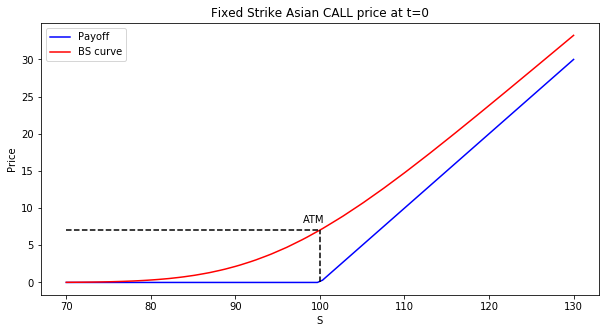

In [16]:
S = np.linspace(70,130, 100)
asian_PDE = S * np.interp( get_X0(S)/S, y, G[:,0])  

fig = plt.figure(figsize=(10,5))
plt.plot(S, np.maximum(S-K,0), color='blue',label="Payoff")
plt.plot(S, asian_PDE, color='red',label="BS curve")
plt.xlabel("S"); plt.ylabel("Price"); plt.text(98, 8, "ATM")
plt.plot([S0, S0], [0, oPrice], 'k--'); plt.plot([70, S0], [oPrice, oPrice], 'k--')
plt.legend(loc='upper left'); plt.title("Fixed Strike Asian CALL price at t=0"); plt.show()

<a id='sec3.3'></a>
## Floating strike. PDE method:

In this case we can simply make a change of variable in the three-dimensional Asian PDE introduced above:

$$ V(t,a,s) := a\, W(t,x) \quad \text{with} \quad x=\frac{s}{a}$$

Let us recall how the partial derivatives change: 

$$ \frac{\partial}{\partial s} = \frac{\partial x}{\partial s} \frac{\partial}{\partial x} = \frac{1}{a} \frac{\partial}{\partial x}, \quad \frac{\partial^2}{\partial s^2} = \frac{1}{a^2} \frac{\partial^2}{\partial x^2}, \quad \frac{\partial}{\partial a} = \frac{\partial x}{\partial a} \frac{\partial}{\partial x} = \frac{-s}{a^2} \frac{\partial}{\partial x}$$

The new PDE in two dimensions is:

$$ \frac{\partial  W(t,x)}{\partial t}  
          + r\,x \frac{\partial W(t,x)}{\partial x} + \frac{x - 1}{t} \biggl( W(t,x) - x \frac{\partial W(t,x)}{\partial x} \biggr)
          + \frac{1}{2} \sigma^2 x^2 \frac{\partial^2  W(t,x)}{\partial x^2} - r  W(t,x)  = 0. $$
          
with terminal conditions:

$$ W(T,x) = (x-1)^+ $$

and lateral conditions:

$$ W(t,0) = 0 \quad \text{ and } \quad W(t,x) \underset{x\to \infty}{\sim} (x-1)^+ $$

We can use the usual implicit discretization in time. 
However, it turns out that the central finite-difference approximation in space creates stability problems.
Instead, the [Upwind scheme](https://en.wikipedia.org/wiki/Upwind_scheme) makes a good job here.    
The discretized PDE is the following:

$$ \begin{aligned}
& \frac{W^{n+1}_{i} -W^{n}_{i}}{\Delta t}  
          + \max \biggl( r\,x_i - x_i \frac{x_i-1}{t_n},\, 0 \biggr) \frac{W^{n}_{i+1} -W^{n}_{i}}{ \Delta x} 
          + \min \biggl( r\,x_i - x_i \frac{x_i-1}{t_n},\, 0 \biggr) \frac{W^{n}_{i} -W^{n}_{i-1}}{ \Delta x} \\ 
&          + \frac{1}{2} \sigma^2 x_i^2  \frac{W^{n}_{i+1} + W^{n}_{i-1} - 2 W^{n}_{i}}{\Delta x^2} 
          + \biggl( \frac{x_i - 1}{t_n} - r \biggr)  W^{n}_i  = 0. 
\end{aligned} $$

In [17]:
Nspace = 4000   # M space steps
Ntime = 7000    # N time steps   
x_max = 10      # A2
x_min = 0       # A1
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)    # space discretization
T_array, dt = np.linspace(0.0001, T, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(x-1,0)                                 # Call payoff

V = np.zeros((Nspace,Ntime))       # grid initialization
offset = np.zeros(Nspace-2)        # vector to be used for the boundary terms   
V[:,-1] = Payoff                   # terminal conditions 
V[-1,:] = x_max-1                  # boundary condition
V[0,:] = 0                         # boundary condition

for n in range(Ntime-2,-1,-1):
    
    # construction of the tri-diagonal matrix D
    sig2 = sig*sig; dxx = dx * dx
    max_part = np.maximum( x[1:-1] * (r - (x[1:-1] - 1)/T_array[n] ), 0 )        # upwind positive part
    min_part = np.minimum( x[1:-1] * (r - (x[1:-1] - 1)/T_array[n] ), 0 )        # upwind negative part
    
    a = min_part * (dt/dx)  - 0.5 * (dt/dxx) * sig2 * (x[1:-1])**2 
    b = 1 + dt*( r - (x[1:-1] - 1)/T_array[n] ) + (dt/dxx) * sig2 * (x[1:-1])**2 \
               + dt/dx * (max_part - min_part)                                      # main diagonal
    c = -max_part * (dt/dx) - 0.5 * (dt/dxx) * sig2 * (x[1:-1])**2 
    
    a0 = a[0]; cM = c[-1]     # boundary terms
    aa = a[1:]; cc = c[:-1]   # upper and lower diagonals 
    D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()     # matrix D
    
    # backward computation
    offset[0] = a0 * V[0,n]
    offset[-1] = cM * V[-1,n]; 
    V[1:-1,n] = spsolve( D, (V[1:-1,n+1] - offset) )   

# finds the option at S0, assuming it is ATM i.e. x=s/a=1
oPrice = S0 * np.interp(1, x, V[:,0])
print("The price of the Floating Strike Asian option by PDE is: ", oPrice)

The price of the Floating Strike Asian option by PDE is:  7.300526237510499


#### Plot:

In [18]:
S = np.linspace(10,200, 100)
A = np.linspace(80,120, 100)
VV = np.zeros((100,100))
for i in range(len(S)):
    for j in range(len(A)):
        VV[i,j] = A[j] * np.interp( S[i]/A[j] , x, V[:,0])       

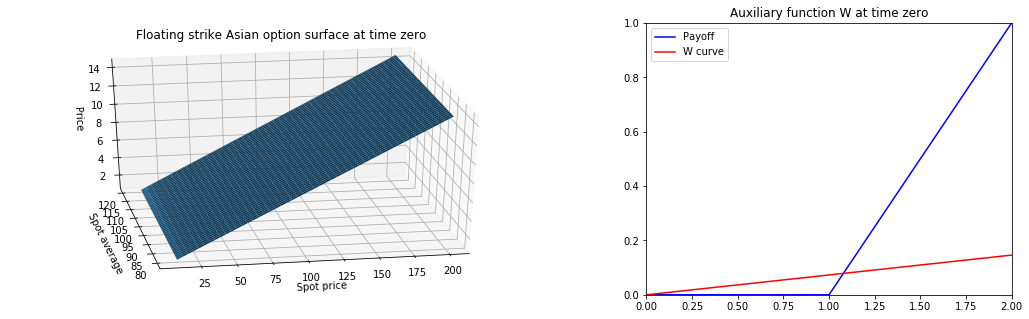

In [19]:
fig = plt.figure(figsize=(18,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,2])
ax1 = fig.add_subplot(gs[0], projection='3d'); ax2 = fig.add_subplot(gs[1])

X, Y = np.meshgrid(A, S)
ax1.plot_surface(Y, X, VV)
ax1.set_title("Floating strike Asian option surface at time zero"); ax1.set_xlabel("Spot price"); 
ax1.set_ylabel("Spot average"); ax1.set_zlabel("Price"); ax1.view_init(30, -100)

ax2.plot(x, Payoff, color='blue',label="Payoff")
ax2.plot(x, V[:,0], color='red',label="W curve")
ax2.set_xlim(0,2); ax2.set_ylim(0,1); ax2.set_title("Auxiliary function W at time zero")
ax2.legend(loc="upper left"); plt.show()

### References

[1]  Daniel Sevcovic, Beata Stehlikova, Karol Mikula (2011). "Analytical and numerical methods for pricing financial derivatives". Nova Science Pub Inc; UK. 

[2] Wilmott Paul (1994). "Option pricing - Mathematical models and computation". Oxford Financial Press.

[3] Steven Shreve (2005). "Stochastic calculus for finance". Springer Finance.